In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd

# Predicting Subscribers Calls following a Network Element Anomaly

Assume some anomaly detection algorithm is able to detect anomalies in network elements in a fairly reliable way. It is natural to think that some subscribers will be impacted by this anomaly. The goal is to use these anomalies and recognize their configurations to predict an increase of calls.

The following is assumed about the prediction model:

- each network element has a subscribers population: the larger the network element, the more subscribers will call following an anomaly on that element
- an anomaly likeliness is estimated by a probability (e.g. could be the z-score of a measurement after removal of the expected signal) and we call rating the negative log of that probability: the higher the rating, the more unlikely the anomaly is
- at peak hour (e.g. from 6:30PM to 10:00PM), more subscribers are using their home devices (e.g. set top box) and will react quickly if a network anomaly occurs.
- during off peak hours, less subscribers are using their devices: calls of those subscribers will be deferred to when they turn them on later in the day: the calls increase is less sudden and spread over more time
- subscribers are assumed to behave the same in different regions at at the same time local to their time zone

### Example of high increase following an severe anomaly at peak hour on a large network element

![High Increase at Peak Hour ](predict_peak_hour.png)

### Example of smaller increase following an severe anomaly at off peak hour on a large network element

![Smaller Increase at Off Peak Hour ](predict_offpeak_hour.png)

** The proof of concept in this notebook uses synthetic data with the assumptions made above to compare logistic regression with a simple neural network **

### Simple crafted data set
Each row in the data set corresponds to one network element anomaly along with the expected number of calls (if there was no anomaly) followed by the actual calls following the 
- the regions of the network elements (not the elements themselves) are one-hot encoded. As the timezone of the network element is assumed to be not available, the model is expected to "learn the local time" given the region and the UTC time
- the UTC time of the anomaly is encoded: in this first limited data set only four values are considered
- rating which the unlikeliness of the anomaly: the higher the more severely the subscribers are impacted
- the population covered by the network element: the larger, the more calls are expected to follow the anomaly
- the expected number of calls (if there was no anomaly, from the median of the calls over the 5 previous weeks at the same time)
- the actual calls following the anomaly after 1h, 2h and 3h.
Note that the calls increase were crafted to respect the assumptions above: more calls in case of higher rating, larger population. Also ** calls spikes are observed during peak hour while during off peak hour calls are shifted and spread over a longer period **. The model is expected to learn this pattern.

In [2]:
data=pd.read_csv('data.csv')
data

,region_east,region_pacific,ano_18h,ano_23h,ano_21h,ano_2h,rating,population,calls,calls+1,calls+2,calls+3
0,1,0,1,0,0,0,30,300,2,4,10,25
1,1,0,0,1,0,0,30,300,4,32,34,30
2,1,0,1,0,0,0,30,600,4,8,20,50
3,1,0,0,1,0,0,30,600,8,64,68,60
4,1,0,0,0,1,0,30,300,3,27,34,32
5,1,0,0,0,0,1,30,300,2,15,15,7
6,1,0,0,0,1,0,30,600,6,54,68,64
7,1,0,0,0,0,1,30,600,4,30,30,14
8,0,1,0,0,1,0,30,300,2,4,10,25
9,0,1,0,0,0,1,30,300,4,32,34,30


In [3]:
X=data.iloc[:,0:9].values
X[:3]

array([[  1,   0,   1,   0,   0,   0,  30, 300,   2],
       [  1,   0,   0,   1,   0,   0,  30, 300,   4],
       [  1,   0,   1,   0,   0,   0,  30, 600,   4]], dtype=int64)

In [4]:
Y=data.iloc[:,9:12].values
Y[:3]

array([[ 4, 10, 25],
       [32, 34, 30],
       [ 8, 20, 50]], dtype=int64)

In [6]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X)  
X_std = scaler.transform(X)  

## Using Neural Network to Predict Calls (using Multilayer Perceptron Regressor)

In [7]:
from sklearn.neural_network import MLPRegressor
regressor=MLPRegressor(hidden_layer_sizes=(100,100), activation='relu', solver='adam', alpha=0.0001, 
                       batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                       power_t=0.5, max_iter=2000, shuffle=True, random_state=None, tol=0.0001, 
                       verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                       early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
                       epsilon=1e-08)

In [8]:
regressor.fit(X_std,Y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [11]:
# predicted calls 1h, 2h, 3h following the anomaly : on training set
regressor.predict(X_std)

array([[  4.01751597,   9.94850869,  25.08601922],
       [ 32.04990559,  33.97456191,  30.0105897 ],
       [  8.00254789,  20.00550341,  49.92479102],
       [ 63.93866273,  68.0465592 ,  59.98397908],
       [ 26.81987163,  34.25348114,  31.88744452],
       [ 14.98573513,  15.07208359,   6.84246168],
       [ 54.09600577,  67.85686358,  64.07628671],
       [ 30.16376266,  29.70065861,  14.35385183],
       [  3.99906557,   9.91756426,  25.01490579],
       [ 32.20282539,  33.60058413,  30.40821066],
       [  8.00978862,  20.06799759,  49.98196747],
       [ 63.81116069,  68.33516923,  59.64402979],
       [  4.04399499,   5.42093679,   5.5806298 ],
       [  9.83637234,  30.22110125,  30.80109953],
       [  8.00026023,   9.68145261,  12.33458018],
       [ 20.14031563,  59.81124926,  62.17101375]])

In [10]:
# actual calls 1h, 2h, 3h following the anomaly
Y

array([[ 4, 10, 25],
       [32, 34, 30],
       [ 8, 20, 50],
       [64, 68, 60],
       [27, 34, 32],
       [15, 15,  7],
       [54, 68, 64],
       [30, 30, 14],
       [ 4, 10, 25],
       [32, 34, 30],
       [ 8, 20, 50],
       [64, 68, 60],
       [ 4,  5,  6],
       [10, 30, 31],
       [ 8, 10, 12],
       [20, 60, 62]], dtype=int64)

#### Without any SSE error measurement, it can be seen above that expected +1h, +2h, +3h calls match fairly the actual calls)

In [12]:
# predicted calls 1h, 2h, 3h following the anomaly : on test set
data_test=pd.read_csv('test.csv')
data_test

,region_east,region_pacific,ano_18h,ano_23h,ano_21h,ano_2h,rating,population,calls
0,1,0,1,0,0,0,30,450,3
1,1,0,1,0,0,0,30,500,4
2,1,0,1,0,0,0,30,550,4
3,1,0,1,0,0,0,30,590,4
4,1,0,1,0,0,0,30,599,4
5,1,0,1,0,0,0,30,600,4
6,1,0,1,0,0,0,30,1200,8


In [13]:
X_test=data_test.values
X_test_std = scaler.transform(X_test)
regressor.predict(X_test_std)

array([[   4.51249882,   13.08295886,   36.02928949],
       [   6.32404407,   16.17408245,   41.9181388 ],
       [   6.98815235,   17.9068261 ,   45.93589914],
       [   7.75989066,   19.55189425,   49.13138509],
       [   7.97808945,   19.960199  ,   49.84559481],
       [   8.00254789,   20.00550341,   49.92479102],
       [  54.09307877,   78.02645002,  109.72637183]])

#### On a test set with manually crafted data, the predicted subscriber behavior is compliant with the expectation. For example:
- row 1: the increase is small on as the anomaly happens during off peak hour (18:00 UTC = 11:00 in region east)
- row 2-6: with increasing population and calls, all predicted +1h, +2h, +3h are increasing

## Using Linear Regression (Ridge) to Predict Calls: not good

In [15]:
from sklearn.linear_model import Ridge
ridge=Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, 
            tol=0.001, solver='auto', random_state=None)

In [16]:
ridge.fit(X_std,Y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [17]:
ridge.predict(X_std)

array([[  8.69965638,   9.36386019,  16.93831994],
       [ 25.17902848,  35.83736074,  31.61931116],
       [ 17.33395168,  22.56131906,  33.26643043],
       [ 52.01615376,  68.97535282,  63.68444194],
       [ 27.7582666 ,  32.96736863,  37.79655416],
       [ 23.59912147,  19.43631401,   9.96254422],
       [ 45.49397689,  56.1350941 ,  61.99317479],
       [ 32.23341678,  32.63377288,  26.2906547 ],
       [  5.16542798,  14.28064144,  26.33949488],
       [ 28.31052782,  30.66038664,  22.11101536],
       [ 13.79972329,  27.47810031,  42.66760537],
       [ 55.14765309,  63.79837871,  54.17614613],
       [ -4.79176725,   0.64739961,  13.3497708 ],
       [ 11.68760485,  27.12090016,  28.03076202],
       [  3.84252805,  13.84485847,  29.67788129],
       [ 38.52473013,  60.25889223,  60.09589279]])

In [18]:
Y

array([[ 4, 10, 25],
       [32, 34, 30],
       [ 8, 20, 50],
       [64, 68, 60],
       [27, 34, 32],
       [15, 15,  7],
       [54, 68, 64],
       [30, 30, 14],
       [ 4, 10, 25],
       [32, 34, 30],
       [ 8, 20, 50],
       [64, 68, 60],
       [ 4,  5,  6],
       [10, 30, 31],
       [ 8, 10, 12],
       [20, 60, 62]], dtype=int64)

The problem is not linearly well separable, partly due to the local time that is expected to be inferred from the UTC time and the region (assumed the timezone of each region is not available). The linear model learns coefficients for features but can't learn a coefficient for a combination of features. It is possible to add combined features (region + time) but this adds many features to the model which makes it more complex while the neural network better handles these combinations.
### At this step the simple synthetic data gives fairly good results. Let's generate much more data (still synthetic) respecting the subscribers behavior for random combinations a larger range for population, rating, time, and calls (baseline and post-anomaly)

In [19]:
# Assume we have 4 regions from 0 to 3, each in its timezone from UTC-4 (e.g. Boston) to UTC-7 (Pacific)
REGIONS_NB=4
region_names= [ 'utc-' + str(4+i) for i in range(0,REGIONS_NB) ]

columns=[]

regions=np.zeros(REGIONS_NB)
region_idx = np.random.randint(REGIONS_NB)
regions[region_idx]=1
columns += regions.tolist()

# select the UTC time of the anomaly (1 hour between 0-24) and local to the region
ano_hour_utc = np.random.randint(24)
ano_hour_local = (ano_hour_utc - 4 - region_idx + 24) % 24
print('region_idx: %d, ano_hour_utc: %d, ano_hour_local: %d' % (region_idx, ano_hour_utc, ano_hour_local))


columns

region_idx: 3, ano_hour_utc: 6, ano_hour_local: 23


[0.0, 0.0, 0.0, 1.0]

In [20]:
region_names= [ 'utc-' + str(4+i) for i in range(0,REGIONS_NB) ]
region_names

['utc-4', 'utc-5', 'utc-6', 'utc-7']

In [21]:
tmp=np.zeros(4)
tmp[2]=1
tmp

array([ 0.,  0.,  1.,  0.])

In [22]:
class CallsFunction:

    def __init__(self):
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.linear_model import LinearRegression
        self.base_pop = 500 # numbers below are for this base population
        self.X=np.array([0,2,4,6,6.75,7.5,8.2,9,13,15,17,19.5,21,23,23.99]).reshape(-1,1)
        self.y=np.array([10,3,3,3,14,30,30,20,21,23,40,60,47,13,10])
        self.quadratic = PolynomialFeatures(degree=10)
        X_quad = self.quadratic.fit_transform(self.X)
        self.pr = LinearRegression()
        self.pr.fit(X_quad, self.y)

    def plot(self, population):
        fig = plt.figure(figsize=(12,10)) 
        ax = fig.add_subplot(1, 1, 1)

        hours,calls_for_pop = self.__get_plot_calls(population)
        ax.plot(hours,calls_for_pop)
        
        support_hours,support_points = self.__get_plot_support_points(population)
        ax.scatter(support_hours, support_points)
        plt.xlim(0,24)
        plt.ylim(0,self.get_ylim(population))
        plt.grid(True)
        plt.xticks(np.arange(24), [ str(i) for i in np.arange(24)])
        return ax
    
    def __get_plot_support_points(self, population):
        return (self.X, [ self.adjust_for_pop(calls, population) for calls in self.y ])
    
    def __get_plot_calls(self, population):
        hours = np.arange(0,24,0.1).reshape(-1,1)
        all_calls = self.pr.predict(self.quadratic.fit_transform(hours))
        calls_for_pop=[ self.adjust_for_pop(calls, population) for calls in all_calls ]
        return (hours,calls_for_pop)

    def adjust_for_pop(self, calls, population):
        return calls * population / self.base_pop
    
    def get_ylim(self,population):
        hours,calls_for_pop = self.__get_plot_calls(population)
        support_hours,support_points = self.__get_plot_support_points(population)
        return max( max(calls_for_pop), max(support_points) )*1.05
    
    def get_calls_for_local_hour(self,hour,population):
        calls = self.pr.predict(self.quadratic.fit_transform(np.array([hour]).reshape(-1,1)))[0]
        return self.adjust_for_pop(calls, population)

### Use interpolation to generate a typical expected calls baseline during a normal day
The graph below shows the points used to generate a polynomial curve for the expected call rate

8.8406614987115617

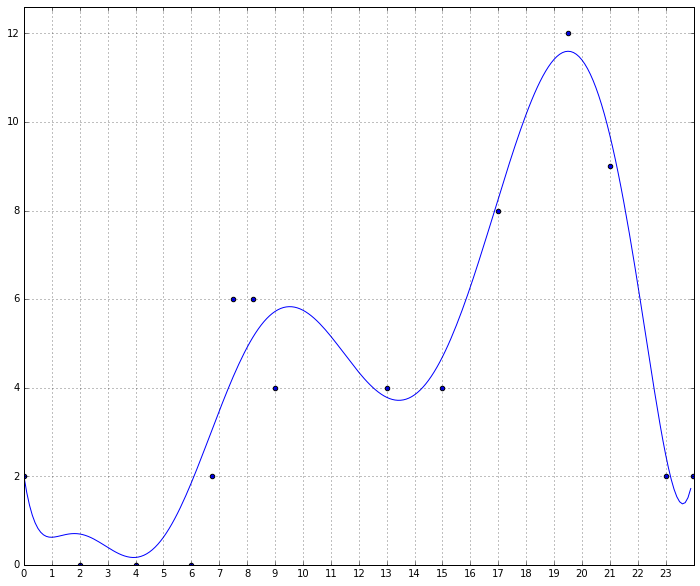

In [23]:
calls_function = CallsFunction()
calls_function.plot(100)
calls_function.get_calls_for_local_hour(21.3,100)

In [24]:
class PostAnomalyCallsFunction:

    def __init__(self):
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.linear_model import LinearRegression
        
        # percentage of calls in ano_hour +1
        self.X1=np.array( [0, 1,   2,  3,  5,   6,  7, 8.2,  9,  10, 13, 15, 16, 17.5, 19,  22, 23.99    ]).reshape(-1,1)
        self.y1=np.array([.4,.2, .05, .05,.05, .2, .8, .8,   .6, .2, .2, .2, .55, .85, .85, .6, .3])
        self.quadratic1 = PolynomialFeatures(degree=8)
        X_quad = self.quadratic1.fit_transform(self.X1)
        self.pr1 = LinearRegression()
        self.pr1.fit(X_quad, self.y1)
        
        # percentage of calls in ano_hour +2
        self.X2=np.array( [0,   1,   2,  3,   4,   6, 7.5, 8.2, 9,  13, 15,  17, 19, 21,  23,  23.99    ]).reshape(-1,1)
        self.y2=np.array([.05,.05, .05, .05,.15, .3, .15,  .15, .2, .2, .3, .3, .1, .1,  .1, .05])
        self.X2=np.array( [0,   1,   2,  3,   4,   6, 7.5, 8.2, 9,  13, 15,  17, 19, 21,  23,  23.99    ]).reshape(-1,1)
        self.y2=np.array([.05,.05, .05, .05,.15, .3, .15,  .15, .2, .2, .3, .3, .1, .1,  .1, .05])
        self.quadratic2 = PolynomialFeatures(degree=12)
        X_quad = self.quadratic2.fit_transform(self.X2)
        self.pr2 = LinearRegression()
        self.pr2.fit(X_quad, self.y2)
        
        # percentage of calls in ano_hour +3
        self.X3=np.array( [0,   1,   2,  3,   4,   6, 7.5, 8.2,  9,   13,  15,  17,  19,  21,  23,  23.99    ]).reshape(-1,1)
        self.y3=np.array([.05,.05, .05, .15,.25, .2, .05,  .05, .05, .05, .35, .15, .05, .05, .05, .05])
        self.X3=np.array( [0,   1,   2,  3,   4,   6, 7.5, 8.2,  9,   13, 14, 16, 17,  19,  21,  23,  23.99    ]).reshape(-1,1)
        self.y3=np.array([.05,.05, .05, .15,.25, .2, .05,  .05, .05, .05, .5, .2, .15, .05, .05, .05, .05])
        self.quadratic3 = PolynomialFeatures(degree=8)
        X_quad = self.quadratic3.fit_transform(self.X3)
        self.pr3 = LinearRegression()
        self.pr3.fit(X_quad, self.y3)
        
        self.cf = CallsFunction()
        
    def plot_ano_calls_rate(self):
        fig = plt.figure(figsize=(15,13)) 
        X_fit = np.arange(0,24,0.1).reshape(-1,1)
        title_fmt='Percent of calls due to anomaly for hour + %d'
        
        ax1 = fig.add_subplot(3, 1, 1)
        y_quad_fit = self.pr1.predict(self.quadratic1.fit_transform(X_fit))
        ax1.plot(X_fit,y_quad_fit)
        ax1.scatter(self.X1,self.y1)
        plt.xlim(0,24)
        plt.ylim(0,1)
        plt.grid(True)
        plt.title(title_fmt % 1)
        plt.xticks(np.arange(24), [ str(i) for i in np.arange(24)])

        ax2 = fig.add_subplot(3, 1, 2)
        y_quad_fit = self.pr2.predict(self.quadratic2.fit_transform(X_fit))
        ax2.plot(X_fit,y_quad_fit)
        ax2.scatter(self.X2,self.y2)
        plt.xlim(0,24)
        plt.ylim(0,1)
        plt.grid(True)
        plt.title(title_fmt % 2)
        plt.xticks(np.arange(24), [ str(i) for i in np.arange(24)])

        ax3 = fig.add_subplot(3, 1, 3)
        y_quad_fit = self.pr3.predict(self.quadratic3.fit_transform(X_fit))
        ax3.plot(X_fit,y_quad_fit)
        ax3.scatter(self.X3,self.y3)
        plt.xlim(0,24)
        plt.ylim(0,1)
        plt.grid(True)
        plt.title(title_fmt % 3)
        plt.xticks(np.arange(24), [ str(i) for i in np.arange(24)])
        
    def __get_percent(self, pr, quadratic, ano_hour_local):
        return max(0.0, pr.predict(quadratic.fit_transform(np.array([ano_hour_local]).reshape(-1,1)))[0])
        
    def get_predicted_calls(self,population, ano_rating, ano_hour_local, debug=None):
        # Get the normal calls adjusted for the population for the hour of the anomaly
        normal_calls_for_ano = self.cf.get_calls_for_local_hour(ano_hour_local, population)
        if (debug is True):
            print('normal_calls at ano hour(%d): %s' % (ano_hour_local, str(normal_calls_for_ano)))

        # Compute the calls added by the anomaly for hours +1, +2, +3.
        # Assuming only ratings > 20 trigger additional calls.
        # With the following formula, the rate of anomaly_calls/normal_calls is:
        # rating = 100 ==> anomaly_calls = 1.90 * normal_calls
        # rating =  50 ==> anomaly_calls = 1.49 * normal_calls
        # rating =  25 ==> anomaly_calls = 0.77 * normal_calls
        # rating =  23 ==> anomaly_calls = 0.60 * normal_calls
        # rating =  21 ==> anomaly_calls = 0.30 * normal_calls
        # rating =  20 ==> anomaly_calls = 0.00 * normal_calls
        ano_calls_rate = np.log10(max(ano_rating-19,1))
        if (debug is True):
            print('ano_calls_rate for rating: ' + str(ano_calls_rate))
        ano_calls = ano_calls_rate * normal_calls_for_ano
        if (debug is True):
            print('ano_calls for rating: ' + str(ano_calls))

        # distribute anomaly_calls for hour +1, +2, +3
        ano_calls_plus_1h = max(0,int(round(ano_calls * self.__get_percent(self.pr1, self.quadratic1, ano_hour_local))))
        ano_calls_plus_2h = max(0,int(round(ano_calls * self.__get_percent(self.pr2, self.quadratic2, ano_hour_local))))
        ano_calls_plus_3h = max(0,int(round(ano_calls * self.__get_percent(self.pr3, self.quadratic3, ano_hour_local))))
        calls_due_to_ano = [ano_calls_plus_1h, ano_calls_plus_2h, ano_calls_plus_3h]

        # compute normal calls for hour +1, +2, +3
        next_hours = [ (ano_hour_local + 1 + i+24) % 24 for i in range(3)]
        normal_calls = [self.cf.get_calls_for_local_hour(hour, population) for hour in next_hours]

        predicted_calls = [a+b for a,b in zip(normal_calls, calls_due_to_ano)]
        return normal_calls_for_ano, normal_calls, predicted_calls

    
    def plot_predicted_calls(self, population, ano_rating, ano_hour_local):
        # plot the normal calls
        ax = self.cf.plot(population)
        ylim = self.cf.get_ylim(population) # max of the normal graph
        
        normal_calls_for_ano, normal_calls, predicted_calls = \
            self.get_predicted_calls(population, ano_rating, ano_hour_local, debug=True)
        print('normal_calls: ' + str(normal_calls))
        print('predicted calls: ' + str(predicted_calls))

        # mark calls at the time of the anomaly with green cross
        ax.scatter([ano_hour_local],[normal_calls_for_ano], c='g',marker='o', s=300)
        
        # plot the calls (normal calls + predicted calls (normal + due to ano)) for the 3 next hours
        next_hours = [ (ano_hour_local + 1 + i+24) % 24 for i in range(3)]
        ax.scatter(next_hours, normal_calls, c='g',marker='o', s=60)
        ax.scatter(next_hours, predicted_calls, c='r',marker='o', s=60)
        plt.grid(True)
        plt.ylim(0, max(ylim, max(predicted_calls))*1.05)
        plt.xticks(np.arange(24), [ str(i) for i in np.arange(24)])
        plt.ylabel('Calls per hour')
        plt.xlabel('Hour of the day (local to timezone)')

In [25]:
postAnoCallFunction = PostAnomalyCallsFunction()
postAnoCallFunction.get_predicted_calls(population=1000, ano_rating=29, ano_hour_local=10)

(57.48116087835124,
 [51.594436320354795, 43.486797281200417, 37.818159447284962],
 [75.594436320354788, 50.486797281200417, 40.818159447284962])

### Combine +1, +2, +3h increases on a single graph, respecting spikes in peak hour in +1h while more spread during off peak hours

normal_calls at ano hour(6): 37.0669672704
ano_calls_rate for rating: 1.0
ano_calls for rating: 37.0669672704
normal_calls: [69.439612107610827, 98.212675338657576, 114.41381967777382]
predicted calls: [85.439612107610827, 106.21267533865758, 120.41381967777382]


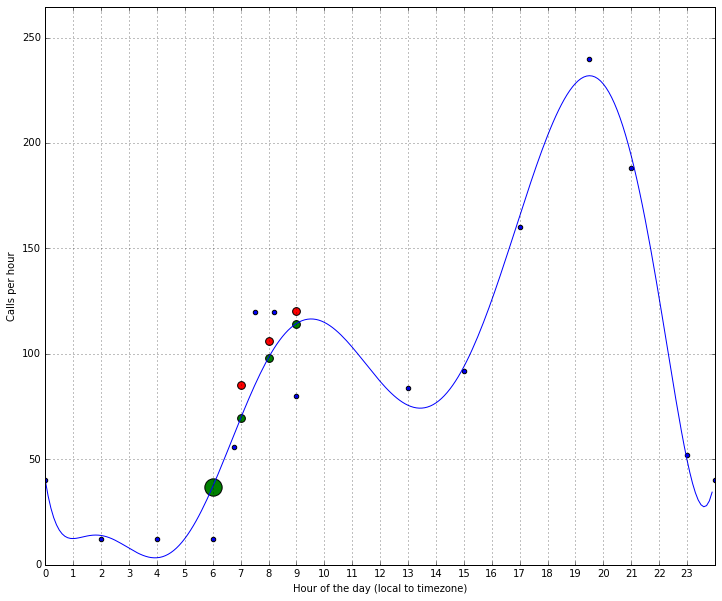

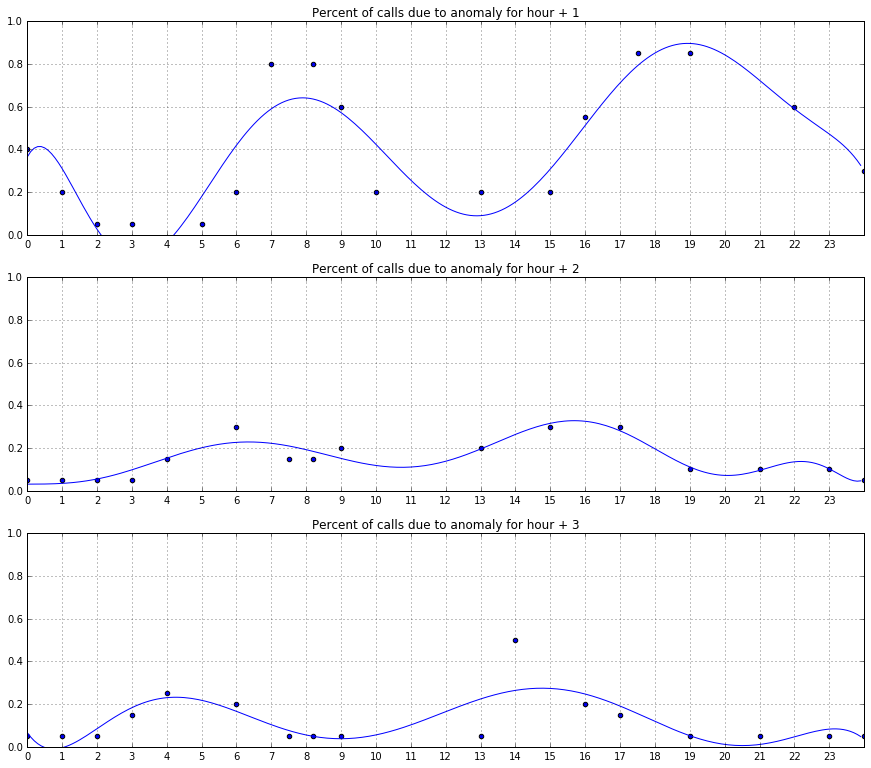

In [54]:
postAnoCallFunction = PostAnomalyCallsFunction()
postAnoCallFunction.plot_predicted_calls(population=2000, ano_rating=29, ano_hour_local=6)
postAnoCallFunction.plot_ano_calls_rate()

### Example: off peak: +1h, +2h, +3h calls increase is moderate relatively to the expected call rate (blue curve)

normal_calls at ano hour(12): 43.4867972812
ano_calls_rate for rating: 1.0
ano_calls for rating: 43.4867972812
normal_calls: [37.818159447284962, 38.382455814834977, 46.947469961860044]
predicted calls: [43.818159447284962, 44.382455814834977, 53.947469961860044]


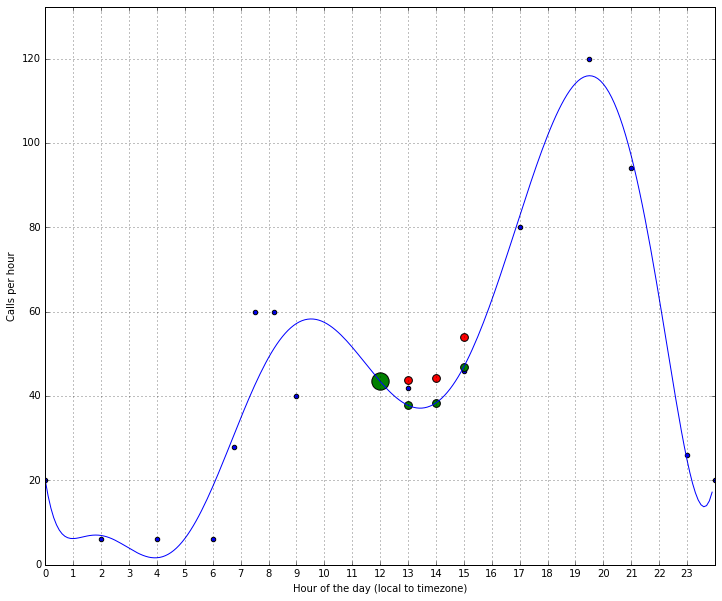

In [28]:
postAnoCallFunction.plot_predicted_calls(population=1000, ano_rating=29, ano_hour_local=12)

In [29]:
class RowGenerator:
    REGIONS_NB=4
    POPULATION_MIN=200
    POPULATION_MAX=700
    region_names= [ 'utc-' + str(4+i) for i in range(0,REGIONS_NB) ]
    RATINGS = [21,30,50,80,120,180]
    RATINGS_PROBAS = [0.3, 0.25, 0.2, 0.12, 0.08, 0.05]
    utc_cols= [ 'hr=%d' % i for i in range(0,24) ]

    def __init__(self):
        self.cf = PostAnomalyCallsFunction()
        
    @staticmethod
    def get_header_columns():
        header = []
        header += RowGenerator.region_names
        header += RowGenerator.utc_cols
        header += ['rating', 'population', 'calls', 'calls+1', 'calls+2', 'calls+3']
        return header

    def __gen_region(self):
        regions_cols=np.zeros(RowGenerator.REGIONS_NB)
        region_idx = np.random.randint(RowGenerator.REGIONS_NB)
        regions_cols[region_idx]=1
        return (region_idx, RowGenerator.region_names[region_idx], regions_cols)
    
    def __gen_hour(self, region_idx):
        ano_hour_utc = np.random.randint(24)
        ano_hour_local = (ano_hour_utc - 4 - region_idx + 24) % 24
        ano_utc_cols=np.zeros(24)
        ano_utc_cols[ano_hour_utc] = 1
        return (ano_hour_utc, ano_hour_local, ano_utc_cols)
    
    def __gen_population(self):
        return np.random.randint(RowGenerator.POPULATION_MIN, RowGenerator.POPULATION_MAX)

    def __gen_rating(self):
        return np.random.choice(RowGenerator.RATINGS, p=RowGenerator.RATINGS_PROBAS)

    def get_row(self, debug=None):
        columns=[]

        # pick region
        region_idx, region_name, regions_cols = self.__gen_region()
        columns += regions_cols.tolist()
        if (debug is True):
            print('region: %s' % region_name)

        # select the UTC time of the anomaly (1 hour between 0-24) and local to the region
        ano_hour_utc, ano_hour_local, ano_utc_cols = self.__gen_hour(region_idx)
        if (debug is True):
            print('ano_hour_utc: %d, ano_hour_local: %d' % (ano_hour_utc, ano_hour_local))
        columns += ano_utc_cols.tolist()

        # pick rating
        rating = self.__gen_rating()
        columns.append(rating)
        
        # pick population
        population = self.__gen_population()
        if (debug is True):
            print('population: %d, rating: %d' % (population, rating))
        columns.append(population)

        # calls for the anomaly plus predicted calls
        normal_calls_for_ano, _, predicted_calls = self.cf.get_predicted_calls(population, rating, ano_hour_local)

        if (debug is True):
            print('normal_calls_for_ano: %d, predicted_calls: %s' % (normal_calls_for_ano, str(predicted_calls)))
        columns.append(normal_calls_for_ano)
        columns += predicted_calls

        return columns
    
    def plot_random(self):
        region_idx, region_name, _ = self.__gen_region()
        _, ano_hour_local,_ = self.__gen_hour(region_idx)
        population = self.__gen_population()
        rating = self.__gen_rating()
        print('region_name: %s, rating: %d, population: %d, ano_hour_local: %d' % \
              (region_name, rating, population, ano_hour_local))
        self.cf.plot_predicted_calls(population, rating, ano_hour_local)


In [30]:
generator = RowGenerator()
generator.get_row(True)

region: utc-5
ano_hour_utc: 3, ano_hour_local: 22
population: 585, rating: 21
normal_calls_for_ano: 37, predicted_calls: [21.547515866340923, 13.685990641645127, 4.6384210025850621]


[0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 21,
 585,
 37.035056721760277,
 21.547515866340923,
 13.685990641645127,
 4.6384210025850621]

## Use a random data generator to generate various configurations

region_name: utc-6, rating: 50, population: 455, ano_hour_local: 16
normal_calls at ano hour(16): 28.5522393729
ano_calls_rate for rating: 1.49136169383
ano_calls for rating: 42.581716074
normal_calls: [37.607379823811868, 46.288891283601956, 51.92869087454249]
predicted calls: [59.607379823811868, 60.288891283601956, 62.92869087454249]


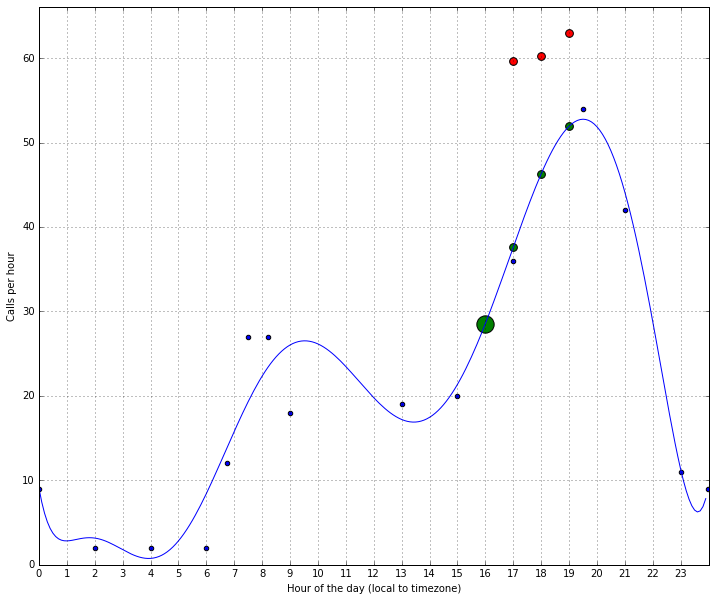

In [38]:
generator.plot_random()

## Use the generator to generate a larger data set

In [43]:
data = pd.DataFrame([generator.get_row() for i in range(1000)], columns=RowGenerator.get_header_columns())
data[:3]

,utc-4,utc-5,utc-6,utc-7,hr=0,hr=1,hr=2,hr=3,hr=4,hr=5,...,hr=20,hr=21,hr=22,hr=23,rating,population,calls,calls+1,calls+2,calls+3
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,30,356,1.404014,0.593245,2.215413,6.597920
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,180,639,40.453677,68.890363,24.764697,7.974275
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,50,635,72.471909,169.388491,73.583908,46.200446


In [44]:
X=data.iloc[:,0:-3].values
Y=data.iloc[:,-3:].values

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=0)

In [46]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train_std = scaler.transform(X_train)  

In [47]:
from sklearn.neural_network import MLPRegressor
regressor=MLPRegressor(hidden_layer_sizes=(100,100), activation='relu', solver='adam', alpha=0.0001, 
                       batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                       power_t=0.5, max_iter=2000, shuffle=True, random_state=None, tol=0.0001, 
                       verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                       early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
                       epsilon=1e-08)

In [48]:
regressor.fit(X_train_std,Y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [49]:
X_test_std = scaler.transform(X_test)  

### Comparing expected calls increase to actual: results are faily good

In [50]:
np.set_printoptions(suppress=True)
regressor.predict(X_test_std)

array([[  95.77760772,   91.33078777,   92.63042552],
       [  28.2010991 ,   12.86174022,    7.18313825],
       [  65.20936444,   37.34175784,   29.31619591],
       [  21.54976504,   15.80243523,   15.69678115],
       [  77.76584101,   42.01105918,   31.57653095],
       [  54.64588509,   26.0342186 ,    9.29938089],
       [  49.88179539,   62.00959581,   71.39080542],
       [   3.79767928,    0.89201762,    0.98577095],
       [  72.31316715,   18.68073469,    7.52348619],
       [  32.07750108,   39.65226932,   48.91590068],
       [  47.7952165 ,   36.48919173,   31.04470096],
       [  79.21992708,   33.80137076,   13.47030578],
       [   3.1081483 ,    7.17564837,   14.09360779],
       [  55.21846011,   19.20061351,    7.09972674],
       [  41.90537311,   50.38523635,   53.91458376],
       [   1.59112222,    7.94907731,   14.8168349 ],
       [  55.70257418,   37.53205926,   31.05817918],
       [  21.07027699,   29.00313338,   34.22124027],
       [   2.14662278,    0.

In [51]:
Y_test

array([[  90.27893235,   91.50154211,   95.09139072],
       [  21.72158871,   13.82582301,    4.68195766],
       [  60.71839532,   34.04839523,   25.78325984],
       [  21.91636414,   16.71126402,   16.93077531],
       [  67.87463471,   37.84139867,   29.53658063],
       [  49.40508273,   26.06988455,    9.8475492 ],
       [  50.64323509,   61.94723459,   70.78481373],
       [   3.43571057,    1.94826692,    0.82321084],
       [  77.05827527,   17.41420476,   10.16900804],
       [  27.91036534,   39.62306113,   49.33494803],
       [  44.5212771 ,   38.47923943,   32.03441028],
       [ 108.43737521,   39.88259189,   14.70201922],
       [   2.60746637,    7.76552964,   14.54759874],
       [  48.84513335,   16.47291322,   11.62606248],
       [  40.780844  ,   48.27155301,   52.78740097],
       [   2.89372759,    8.61806989,   16.14470982],
       [  58.7550204 ,   38.71731786,   31.83398672],
       [  20.54725081,   28.64686811,   33.20749024],
       [   0.37494421,    1.

### This notebook with synthetic data shows the ability of a simple neural network to predict increases of subscriber calls following network element anomalies of various of configurations. However nothing replace real wild data that might require much more cleansing, feature engineering and tuning
